## In this notebook, we loaded 10K reports in JSON format and conducted EDA on the data (Item 7), such as:
- Get distribution of word tokens and sentences
- Calculate average word count 
- Check the most frequent words

### Set Up and Preparation

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import packages
import pandas as pd
import numpy as np
import json
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load data in extracted JSON format
# all reports have the same set of keys
file_list = glob.glob('/content/drive/MyDrive/w210_capstone_project/data/SEC_Edgar_Annual_Financial_Filings_2021/extracted/*.json')
df = []
for file in file_list:
    with open(file, 'r') as f:
        df.append(json.load(f))
df = pd.DataFrame(df)

In [ ]:
df.shape

(191, 33)

In [ ]:
# each row is a 10K report
df.head()

,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,1001601,"MGT CAPITAL INVESTMENTS, INC.",10-K,2021-04-15,2020-12-31,7374,DE,NC,1231,https://www.sec.gov/Archives/edgar/data/100160...,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nSummary Compe...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,1013857,PEGASYSTEMS INC,10-K,2021-02-17,2020-12-31,7374,MA,MA,1231,https://www.sec.gov/Archives/edgar/data/101385...,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,"ITEM 9B. OTHER INFORMATION\nOn February 12, 20...","ITEM 10. DIRECTORS, EXECUTIVE OFFICERS, AND CO...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...
2,1002517,"Nuance Communications, Inc.",10-K,2021-11-18,2021-09-30,7372,DE,MA,0930,https://www.sec.gov/Archives/edgar/data/100251...,...,Item 8.\nItem 8.Financial Statements and Suppl...,Item 9.Changes in and Disagreements with Accou...,Item 9A.Controls and Procedures\nDisclosure Co...,Item 9B.Other Information\nNone\nPART III\nCer...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
3,1013462,ANSYS INC,10-K,2021-02-24,2020-12-31,7372,DE,PA,1231,https://www.sec.gov/Archives/edgar/data/101346...,...,ITEM 8.FINANCIAL STATEMENTS AND SUPPLEMENTARY ...,ITEM 9.CHANGES IN AND DISAGREEMENTS WITH ACCOU...,ITEM 9A.CONTROLS AND PROCEDURES\nEvaluation of...,ITEM 9B.OTHER INFORMATION\nNone.\nPART III,"ITEM 10.DIRECTORS, EXECUTIVE OFFICERS AND CORP...",ITEM 11.EXECUTIVE COMPENSATION\nThe informatio...,ITEM 12.SECURITY OWNERSHIP OF CERTAIN BENEFICI...,ITEM 13.CERTAIN RELATIONSHIPS AND RELATED TRAN...,ITEM 14.PRINCIPAL ACCOUNTANT FEES AND SERVICES...,ITEM 15.EXHIBIT AND FINANCIAL STATEMENT SCHEDU...
4,1023731,8X8 INC /DE/,10-K,2021-05-17,2021-03-31,7374,DE,CA,0331,https://www.sec.gov/Archives/edgar/data/102373...,...,ITEM 8. CONSOLIDATED FINANCIAL STATEMENTS AND ...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nChanges in I...,"ITEM 9B. OTHER INFORMATION\nOn May 13, 2021, u...","ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nInformation r...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...


### Data Cleaning and Processing

In [ ]:
titles = ["item 7. management’s discussion and analysis of financial condition and results of operations"]
          #"item 7a. quantitative and qualitative disclosures about market risk",
          #"item 8. financial statements and supplementary data"]

# function to clean/process text data
def clean_text(x):
  # lowercase
  x = x.lower()
  # remove section titles
  for t in titles:
    x = re.sub(t, "", x)
  # remove special characters besides period (save period for counting # of sentence later)
  x = re.sub(r'[^0-9a-zA-Z.]', ' ', x)
  # x = re.sub(r'\d+ . \d+', ' ', x)
  # pad space for period when it's not a decimal place
  # x = re.sub(r'\.', r' . ', x)
  # if it is a decimal place 
  # results = re.search(r'(\d+) . (\d+)', x)
  # merge the front and back digits back e.g. 0 . 1 -> 0.1
  #if results:
    # x = re.sub(r'(\d+) . (\d+)', '.'.join(results.groups()), x)
  # x = re.sub(r'(?<=[.,])(?=[^\s])', r' ', x)
  # replace punctuation with space
  # x = re.sub(r'[^\w\s]', ' ', x)
  #x = x.strip(string.punctuation)
  # remove extra space
  x = re.sub(r'\s+', ' ', x)
  # remove trailing space
  return x.strip()

In [ ]:
# clean relevant sections 
df['item_7_cleaned'] = df['item_7'].apply(clean_text)
#df['item_7A_cleaned'] = df['item_7A'].apply(clean_text)
#df['item_8_cleaned'] = df['item_8'].apply(clean_text)

In [ ]:
df['item_7'][0]

'Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations\nOverview\nFollowing a review of its Bitcoin mining operations in early 2019, we determined to consolidate our activities in a Company-owned and managed facility. Central to this strategy was the purchase of land in LaFayette, GA and the entry into a favorable contract for electricity in the second quarter of 2019. Located adjacent to a utility substation, the several acre property has access to over 20 megawatts (MW) of low-cost power.\nThe Company owned approximately 669 and 649 Antminer S17 Pro Bitcoin miners located in LaFayette, GA as of December 31, 2020 and April 15, 2021, respectively. All miners were purchased from Bitmaintech Pte. Ltd., a Singapore limited company (“Bitmain”), and are collectively rated at approximately 30 Ph/s in computing power. Bitmain has acknowledged manufacturing defects, combined with inadequate repair facilities, rendering approximately one half of our miner

In [ ]:
df['item_7_cleaned'][0]

'overview following a review of its bitcoin mining operations in early 2019 we determined to consolidate our activities in a company owned and managed facility. central to this strategy was the purchase of land in lafayette ga and the entry into a favorable contract for electricity in the second quarter of 2019. located adjacent to a utility substation the several acre property has access to over 20 megawatts mw of low cost power. the company owned approximately 669 and 649 antminer s17 pro bitcoin miners located in lafayette ga as of december 31 2020 and april 15 2021 respectively. all miners were purchased from bitmaintech pte. ltd. a singapore limited company bitmain and are collectively rated at approximately 30 ph s in computing power. bitmain has acknowledged manufacturing defects combined with inadequate repair facilities rendering approximately one half of our miners in need of repair or replacement. the company s miners are housed in three modified shipping containers. the com

### EDA

In [ ]:
# number of word tokens 
df['item_7'].apply(word_tokenize).map(lambda x: len(x))

0       5355
1       5479
2      14913
3      14792
4       6805
       ...  
186    11461
187    12260
188    12431
189     9185
190     4878
Name: item_7, Length: 191, dtype: int64

In [ ]:
# number of word tokens decreased after cleaning
# since we moved titles and most special characters
df['item_7_cleaned'].apply(word_tokenize).map(lambda x: len(x))

0       4940
1       4997
2      13410
3      13850
4       6251
       ...  
186    10408
187    11162
188    11524
189     8305
190     4545
Name: item_7_cleaned, Length: 191, dtype: int64

In [ ]:
# after cleaning, number of words increased b/c in the original version
# e.g. "Operations\nOverview\nFollowing" count as 1 word
# remove period from word count
# def count_without_dot(x):
#   return len([i for i in x if i != '.'])
# df['item_7_cleaned'].str.split().map(lambda x: count_without_dot(x))

In [ ]:
# calculate number of word tokens, sentence tokens, and word per sentence
def word_count(df, col):
  return df[col].apply(lambda x : len(word_tokenize(x)))

def sent_count(df, col):
  return df[col].apply(lambda x : len(sent_tokenize(x)))

def word_per_sent(df, col):
  return df[col].apply(lambda x : [len(word_tokenize(s)) for s in sent_tokenize(x)]).explode()

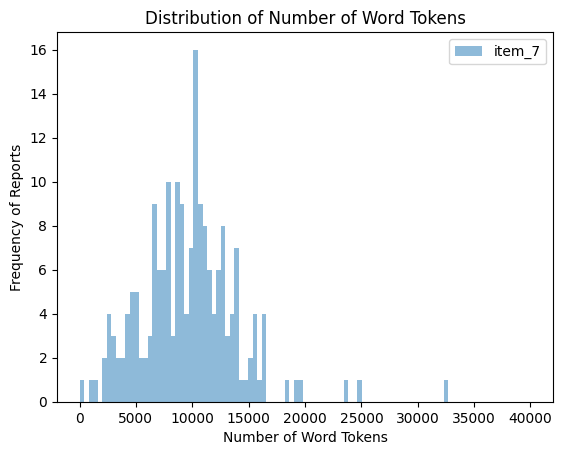

In [ ]:
# plot number of word tokens
bins = np.linspace(0, 40000, 100)
_=plt.hist(word_count(df, 'item_7_cleaned'), bins,alpha=0.5, label="item_7")
#_=plt.hist(word_count(df, 'item_7A_cleaned'), bins,alpha=0.5, label="item_7A")
#_=plt.hist(word_count(df, 'item_8_cleaned'), bins,alpha=0.5, label="item_8")
plt.title("Distribution of Number of Word Tokens")
plt.xlabel("Number of Word Tokens")
plt.ylabel("Frequency of Reports")
plt.legend(loc='best')
plt.show()

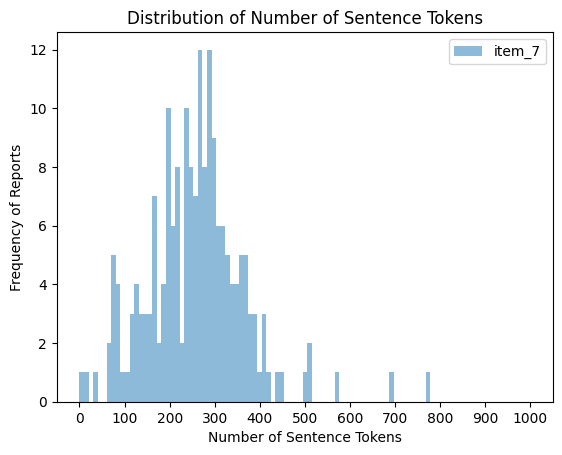

In [ ]:
# plot number of sentence tokens
bins = np.linspace(0, 1000, 100)
_=plt.hist(sent_count(df, 'item_7_cleaned'), bins,alpha=0.5, label="item_7")
#_=plt.hist(sent_count(df, 'item_7A_cleaned'), bins,alpha=0.5, label="item_7A")
#_=plt.hist(sent_count(df, 'item_8_cleaned'), bins,alpha=0.5, label="item_8")
plt.title("Distribution of Number of Sentence Tokens")
plt.xlabel("Number of Sentence Tokens")
plt.ylabel("Frequency of Reports")
plt.legend(loc='best')
plt.xticks(np.arange(0,1100,step=100))
plt.show()

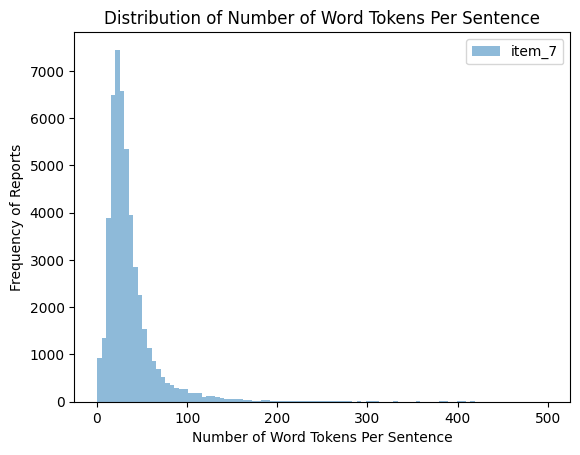

In [ ]:
# plot number of word tokens per sentence
bins = np.linspace(0, 500, 100)
_=plt.hist(word_per_sent(df, 'item_7_cleaned'), bins,alpha=0.5, label="item_7")
#_=plt.hist(word_per_sent(df, 'item_7A_cleaned'), bins,alpha=0.5, label="item_7A")
#_=plt.hist(word_per_sent(df, 'item_8_cleaned'), bins,alpha=0.5, label="item_8")
plt.title("Distribution of Number of Word Tokens Per Sentence")
plt.xlabel("Number of Word Tokens Per Sentence")
plt.ylabel("Frequency of Reports")
plt.legend(loc='best')
#plt.xticks(np.arange(0,1100,step=100))
plt.show()

In [21]:
# table of average number of word and sentence tokens
summaries = pd.DataFrame({'section':['item_7'], #'item_8'],
                          'mean_num_words': [word_count(df, 'item_7_cleaned').mean().round()],
                                             #word_count(df, 'item_7A_cleaned').mean().round(),
                                             #word_count(df, 'item_8_cleaned').mean().round()],
                          'mean_num_sentences': [sent_count(df, 'item_7_cleaned').mean().round()],
                                                 #sent_count(df, 'item_7A_cleaned').mean().round(),
                                                 #sent_count(df, 'item_8_cleaned').mean().round()]})
                          'mean_words_per_sentence': [word_per_sent(df, 'item_7_cleaned').mean().round()]})
                                                      #word_per_sent(df, 'item_7A_cleaned').mean().round(),
                                                      #word_per_sent(df, 'item_8_cleaned').mean().round()]})
summaries

,section,mean_num_words,mean_num_sentences,mean_words_per_sentence
0,item_7,9674.0,258.0,37.0


In [22]:
# function to check numbers 
# may want to remove numbers when displaying the most frequent words
def is_number(x):
  try:
    float(x)
    return True
  except:
    return False

In [23]:
# get most frequent words
stop=set(stopwords.words('english'))

def get_most_freq_words(df, col):
    corpus=[]
    # use NLTK word_tokenize function to count
    tokens=df[col].apply(word_tokenize)
    tokens=tokens.values.tolist()
    # collapse all words in one list
    corpus=[word for i in tokens for word in i]

    # store occurences of each word in a list of tuples (word, count)
    counter=Counter(corpus)
    most=counter.most_common()

    x, y= [], []
    for word,count in most[:40]:
      # when displaying, exclude non-stopwords, dots and numbers
        if (word not in stop and word != '.' and not is_number(word)):
        #if (word not in stop and word != '.'):
            x.append(word)
            y.append(count)
  
    return sns.barplot(x=y,y=x).set(title=f"Most Frequent Word Tokens in {re.sub('_cleaned', '', col)}")

[Text(0.5, 1.0, 'Most Frequent Word Tokens in item_7')]

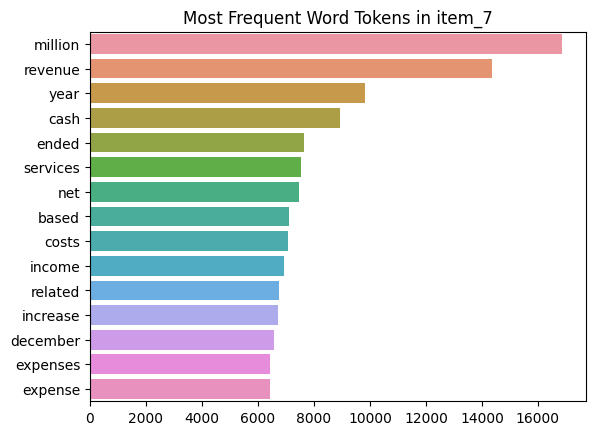

In [24]:
get_most_freq_words(df, 'item_7_cleaned')

In [25]:
#get_most_freq_words(df, 'item_7A_cleaned')

[Text(0.5, 1.0, 'Most Frequent Word Tokens in item_8')]

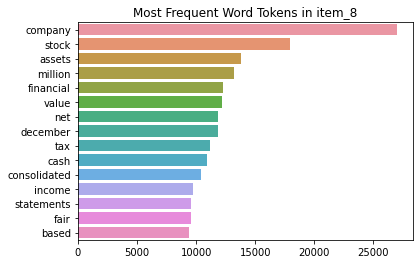

In [ ]:
get_most_freq_words(df, 'item_8_cleaned')

In [ ]:
# check item_8 which contains a lot of tables
sent_tokenize(df['item_8_cleaned'][2])

['item 8. item 8.financial statements and supplementary data nuance communications inc. consolidated financial statements nuance communications inc. index to consolidated financial statements page reports of independent registered public accounting firm consolidated statements of operations consolidated statements of comprehensive loss income consolidated balance sheets consolidated statements of stockholders equity consolidated statements of cash flows notes to consolidated financial statements report of independent registered public accounting firm stockholders and board of directors nuance communications inc. burlington massachusetts opinion on the consolidated financial statements we have audited the accompanying consolidated balance sheets of nuance communications inc. the company as of september 30 2021 and 2020 the related consolidated statements of operations comprehensive income loss stockholders equity and cash flows for each of the three years in the period ended september 3